# Import KPMP Open Clinical Data into an AnnData Object

Created 2025-04-15

This code is meant to ingest the Open Access Clinical Data file for KPMP and create a suitable AnnData object for use with transcriptomic analysis. The current openly accessible clinical data is released as a `.csv.` file (current filename `20241202_OpenAccessClinicalData.csv`). The first column is the Participant ID and serves as the index for the AnnData object and can be used to link the clinical data to downloaded sample data (data in KPMP includes sample and participant IDs). The columns included in the Open Access Clinical Data are as follows:

- Participant ID  
- Tissue Source  
- Protocol  
- Sample Type  
- Enrollment Category  
- Primary Adjudicated Category  
- Sex  
- Age (Years) (Binned)  
- Race  
- KDIGO Stage  
- Baseline eGFR (ml/min/1.73m2) (Binned)  
- Proteinuria (mg) (Binned)  
- A1c (%) (Binned)  
- Albuminuria (mg) (Binned)  
- Diabetes History  
- Diabetes Duration (Years)  
- Hypertension History  
- Hypertension Duration (Years)  
- On RAAS Blockade  

## Ingest the downloaded Open Access Clinical Data file.

The steps performed in this conversion:

*   **Read in the CSV file** without immediately setting the index so that we can clean all column names.
    
*   **Rename all columns** o a standardized snake_case format by lowercasing letters, replacing spaces with underscores, and removing parentheses and slashes.
    
*   **Set the “participant_id” column** (the cleaned name for “Participant ID”) as the index.
    
*   **Define the plotting order for “binned” columns** to that ranges display in a useful way.
    
*   **Create an AnnData object** using the cleaned DataFrame.

*   **Plot each clinical data element from the AnnData object** to check the outcome of the processing.

In [1]:
import pandas as pd
import anndata as ad
import re
import os

# Prompt user to input the path
filename = input("Enter full path to your clinical CSV file: ").strip()

# Validate the file path
if not os.path.isfile(filename):
    raise FileNotFoundError(f"🚫 File not found: {filename}")

# Load the CSV
clinical_df = pd.read_csv(filename)
print(f"✅ Loaded file with shape: {clinical_df.shape}")

# Use the full path if using remotely. If the csv file is in the current working directory as the Jupyter Notebook, you only need to enter the filename.

Enter full path to your clinical CSV file:  OpenAccessClinicalData/20241202_OpenAccessClinicalData.csv


✅ Loaded file with shape: (583, 19)


## Clean the columns of spaces and apply best practices to naming the columns and set the index.

In [3]:
clinical_df.columns = (
    clinical_df.columns
    .str.strip()
    .str.lower()
    .str.replace(r"\s+", "_", regex=True)
    .str.replace(r"[()%]", "", regex=True)
)

# Set the first column as the index
clinical_df.set_index(clinical_df.columns[0], inplace=True)

# Use the following one at a time in the console to check the dataframe
# Check the dataframe
# clinical_df.head()

# Check the shape
# clinical_df.shape

# Check the column names
# clinical_df.columns

## Remove units from the data and store for later.

In [5]:
columns_to_clean = [
    'age_years_binned',
    'baseline_egfr_ml/min/1.73m2_binned',
    'diabetes_duration_years',
    'hypertension_duration_years'
]

# Dictionary to store units
column_units = {}

# Clean values and extract units
for col in columns_to_clean:
    # Drop NA for checking a sample
    sample_val = clinical_df[col].dropna().astype(str).iloc[0]

    # Extract the unit using regex (anything after the main numeric expression)
    match = re.match(r"([<>=]*\d+[-–]?\d*)\s*(.*)", sample_val)
    if match:
        clean_val, unit = match.groups()
        column_units[col] = unit.strip()
        
        # Apply cleaning to the whole column
        clinical_df[col] = clinical_df[col].astype(str).str.extract(r"([<>=]*\d+[-–]?\d*)")[0]
    else:
        column_units[col] = ''  # No unit found

# At this point clinical_df has clean values, and units are stored

## Determine the plotting order for the binned data and select others.

In [7]:
# Define bin orders
age_years_binned_order = [
    "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80-89"
]

egfr_bins_order = [
    "140-149", "120-129", "110-119", "100-109", "90-99", "80-89",
    "70-79", "60-69", "50-59", "40-49", "30-39", "20-29", "10-19"
]


proteinuria_bins_order = [
    "<150 mg/g cr",
    "150 to <500 mg/g cr",
    "500 to <1000 mg/g cr",
    ">=1000 mg/g cr"
]

a1c_bins_order = [
    "<6.5%",
    "6.5 to <7.5%",
    "7.5 to <8.5%",
    ">=8.5%"
]

albuminuria_bins_order = [
    "<30 mg/g cr",
    "30 to <300 mg/g cr",
    "300 to <500 mg/g cr",
    "500 to <1000 mg/g cr",
    ">=1000 mg/g cr"
]

kdigo_stage_order = [
    "Stage 1",
    "Stage 2",
    "Stage 3",
]

diabetes_duration_years_order  = [
        '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64'
]

hypertension_duration_years_order = [
    '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54'
]

# Map column names to bin orders
bin_orders = {
    "age_years_binned": age_years_binned_order,
    "baseline_egfr_ml/min/1.73m2_binned": egfr_bins_order,
    "proteinuria_mg_binned": proteinuria_bins_order,
    "a1c__binned": a1c_bins_order,
    "albuminuria_mg_binned": albuminuria_bins_order,
    "kdigo_stage": kdigo_stage_order,
    "diabetes_duration_years": diabetes_duration_years_order,
    "hypertension_duration_years": hypertension_duration_years_order
}

# Apply the ordered categories 
for col, order in bin_orders.items():
    if col in clinical_df.columns:
        clinical_df[col] = pd.Categorical(clinical_df[col], categories=order, ordered=True)

# (note that the ordering does not always carry through to the anndata object and will be reapplied after conversion)

# Convert to an AnnData object.

In [9]:
adata = ad.AnnData(obs=clinical_df.copy())
adata.uns["bin_orders"] = bin_orders
adata.uns["column_units"] = column_units  # if you're storing units too

# Repeat the ordered columns in teh anndata object
for col, order in adata.uns["bin_orders"].items():
    if col in adata.obs.columns:
        adata.obs[col] = pd.Categorical(adata.obs[col], categories=order, ordered=True)

# Plot all data from the AnnData object.

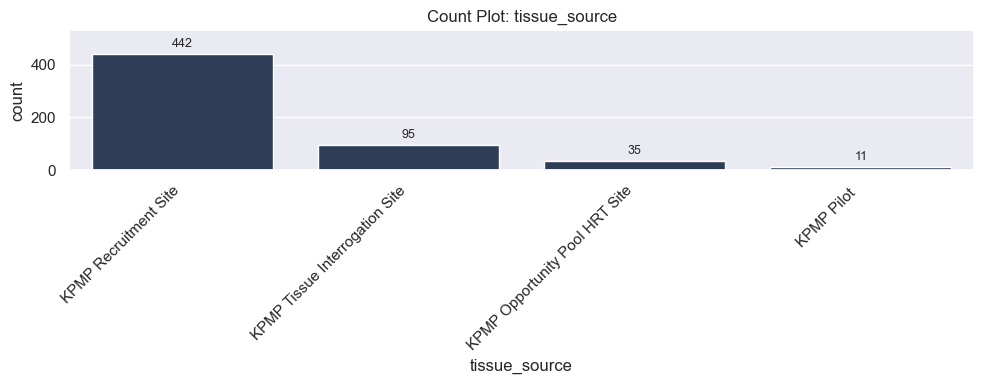

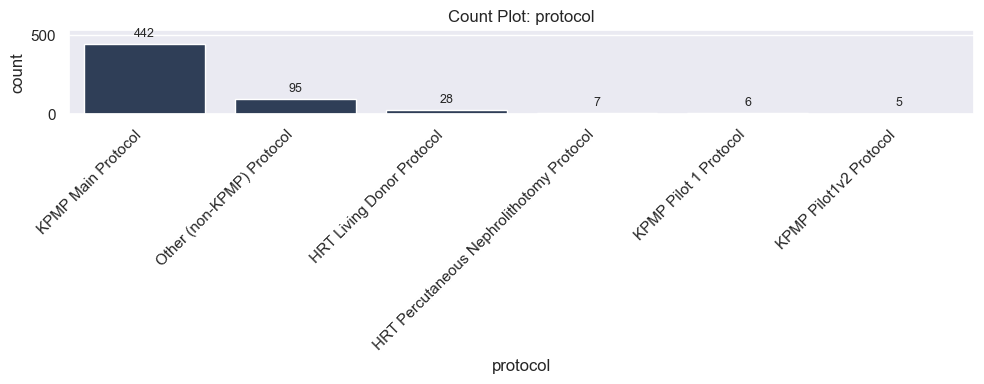

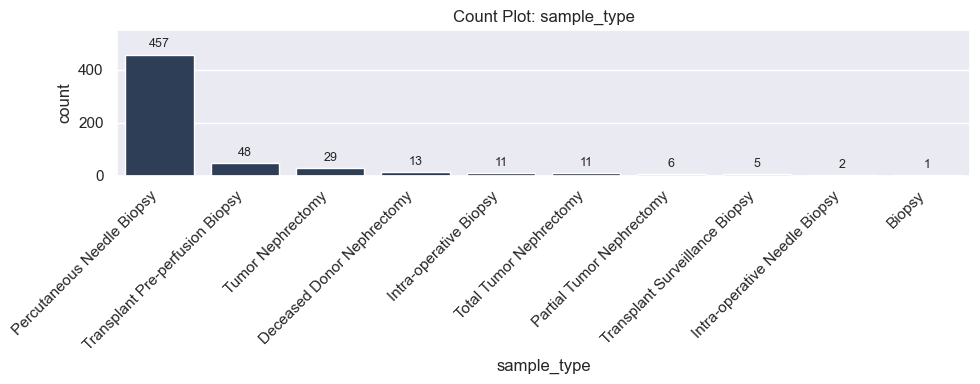

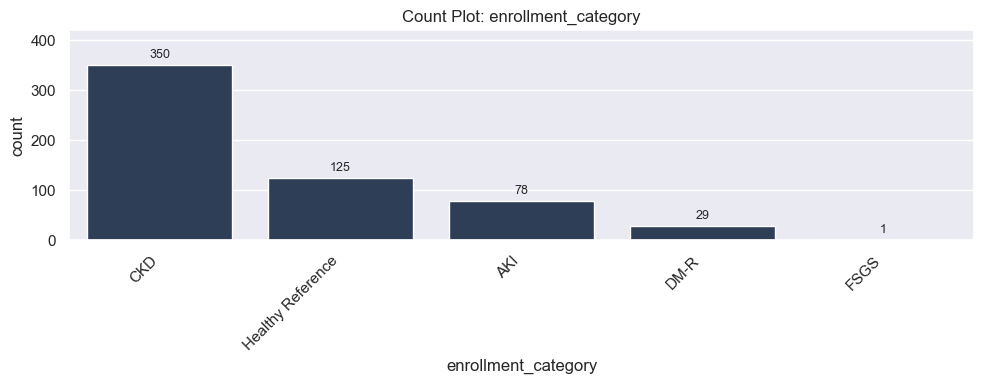

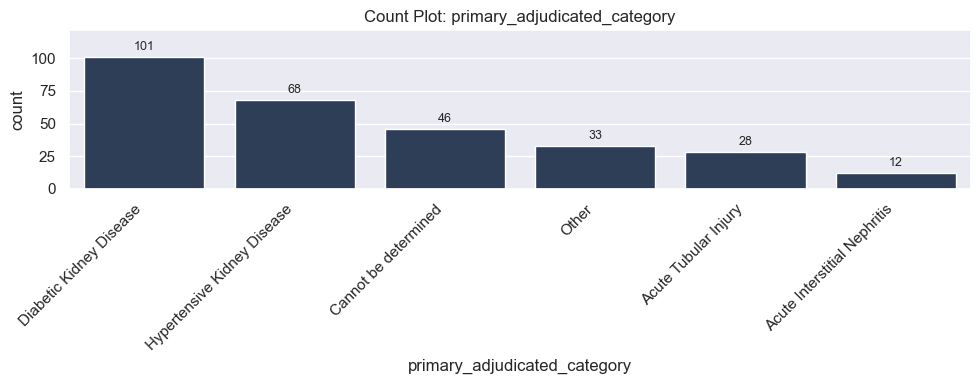

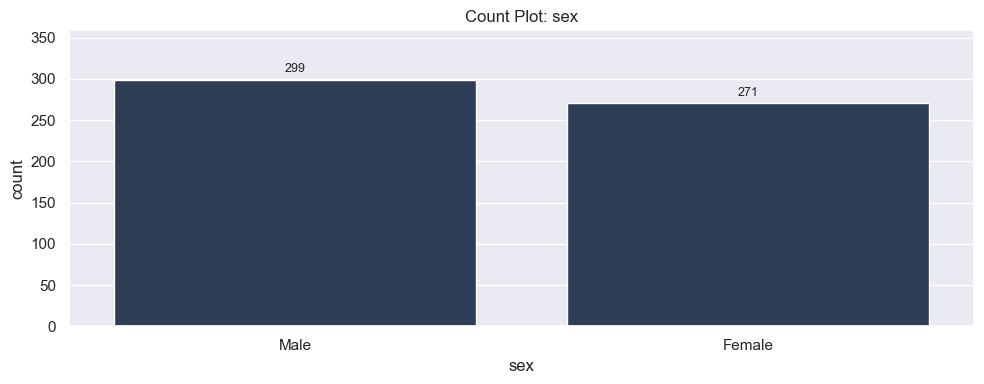

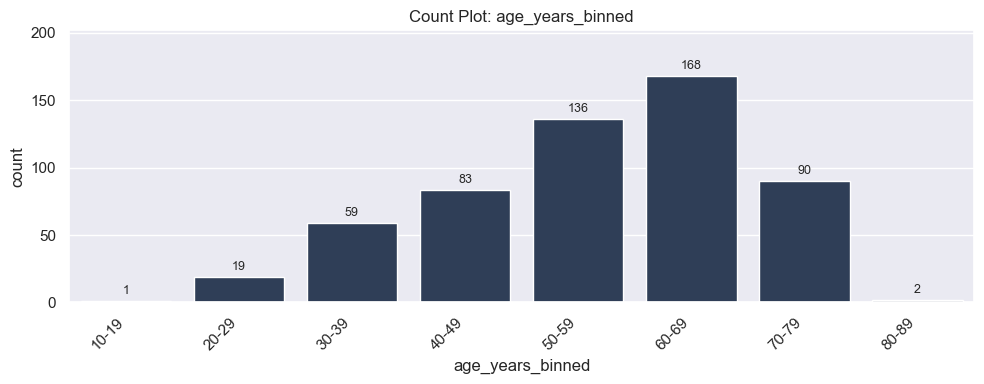

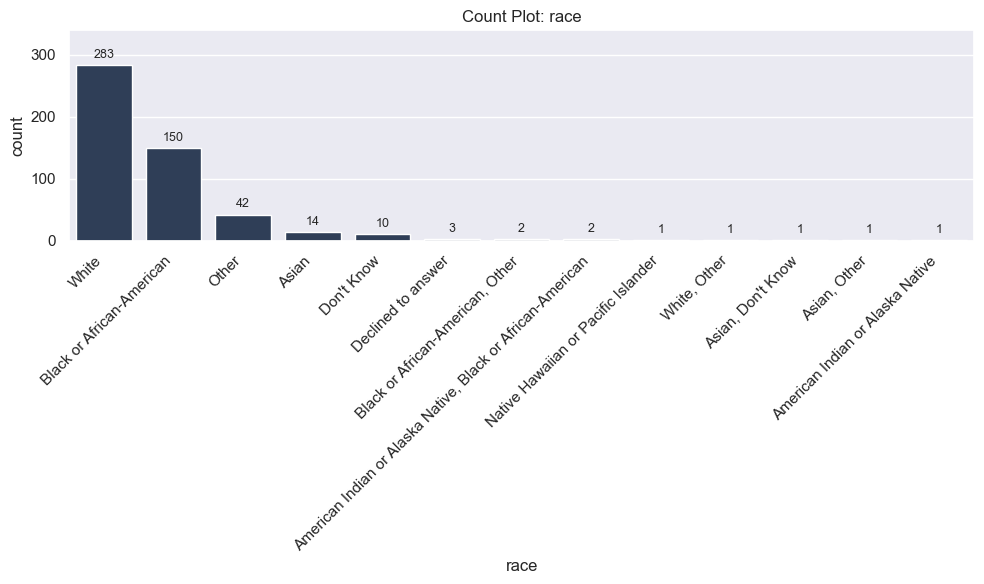

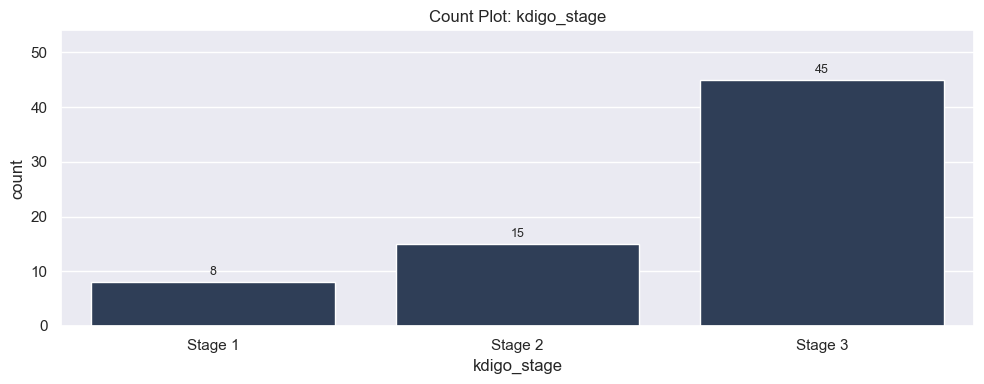

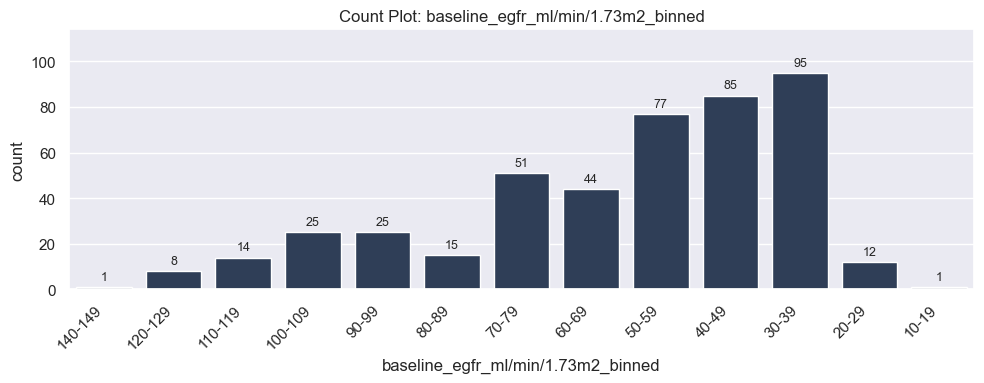

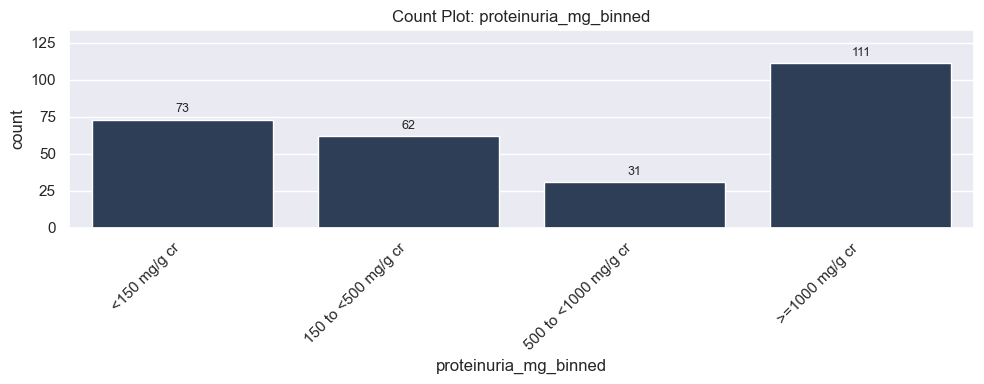

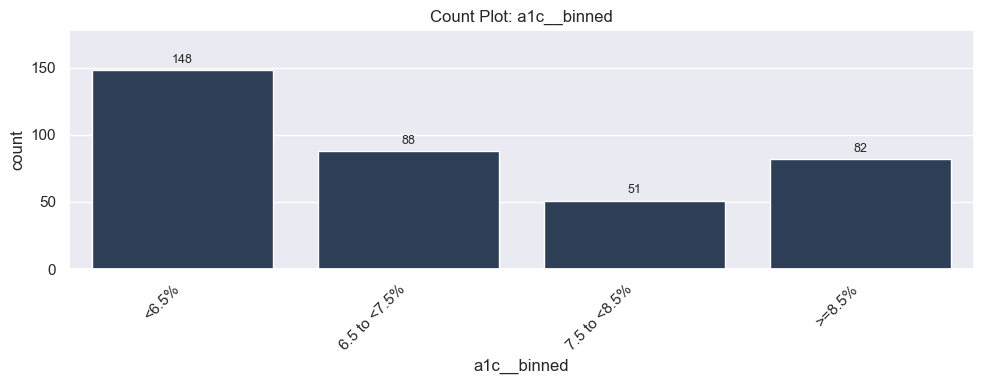

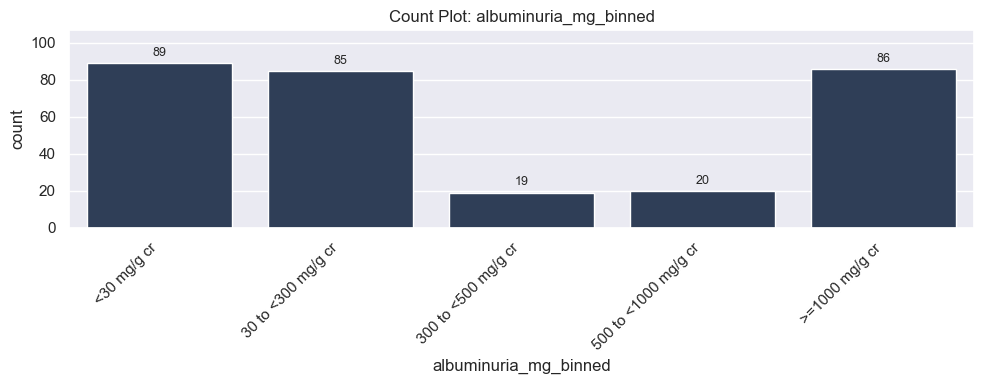

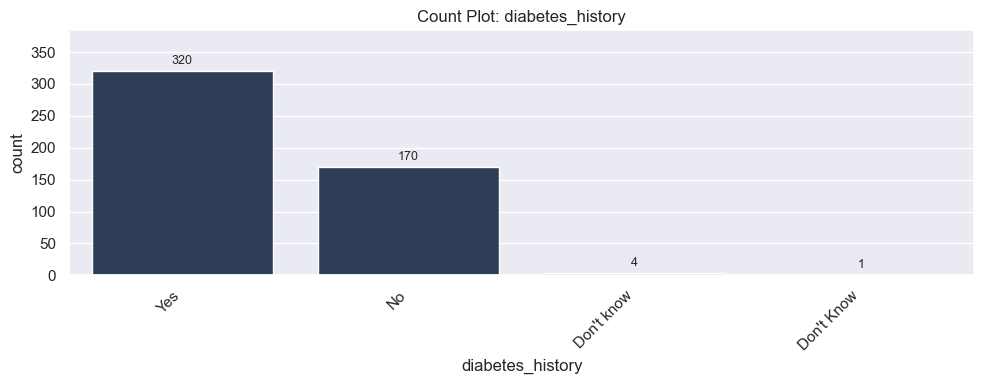

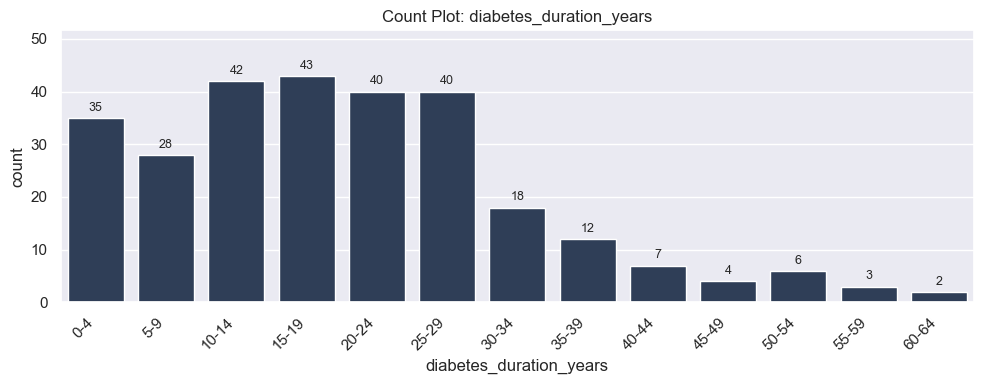

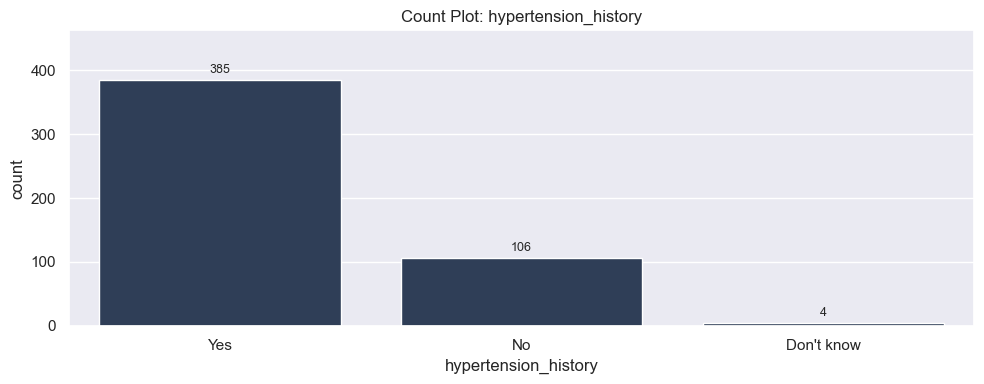

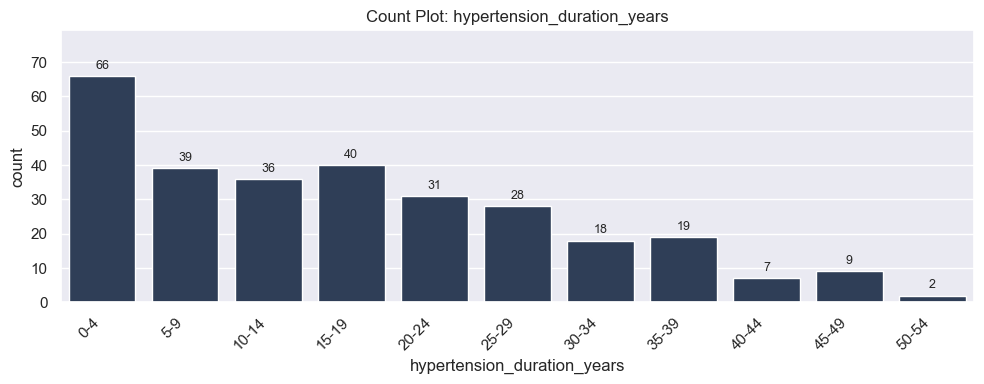

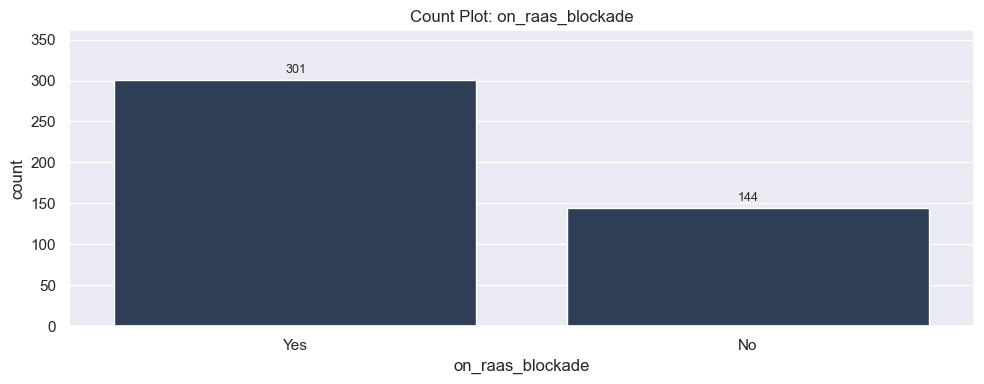

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font='Arial')

def plot_clinical_column(adata, column, figsize=(10, 4)):
    """
    Plots a column from adata.obs with dynamic y-axis handling.
    - Automatically adjusts height if bar labels are tall
    - Pads top of y-axis to avoid overlap
    - Avoids excessive y-tick crowding
    """
    data = adata.obs[column]
    
    # Use taller plot if column likely needs more space (e.g. race)
    if column == "race":
        figsize = (10, 6)  # or (10, 8) if still too short

    plt.figure(figsize=figsize)

    skip_rotation = {"sex", "kdigo_stage", "hypertension_history", "on_raas_blockade"}
    bin_orders = adata.uns.get("bin_orders", {})
    order = bin_orders.get(column, data.value_counts().index)

    if pd.api.types.is_numeric_dtype(data):
        sns.histplot(data.dropna(), bins=10, kde=False, color="#008ea8")
        plt.title(f"Histogram: {column}")
    else:
        ax = sns.countplot(x=data, order=order, color="#283c5e")
        plt.title(f"Count Plot: {column}")

        if column not in skip_rotation:
            plt.xticks(rotation=45, ha="right")

        # Add count labels and pad y-axis
        max_height = 0
        for container in ax.containers:
            heights = [bar.get_height() for bar in container]
            max_height = max(max_height, *heights)
            ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

        # Add y-axis padding
        padded_top = max_height * 1.2
        ax.set_ylim(top=padded_top)

    plt.tight_layout()
    plt.show()
    
# Combine both sets of columns: binned and others
all_cols = list(adata.obs.columns)
for col in all_cols:
    plot_clinical_column(adata, col)

## Save out anndata object as an `.h5ad` file. 

In [ ]:
from datetime import datetime
import os

# Add metadata tags to AnnData object
adata.uns["clinical_data_release_date"] = "2024-12-02"  # Source CSV release date
adata.uns["dataset_name"] = "KPMP Open Access Clinical Metadata"

# Get current date in YYYYMMDD format
date_tag = datetime.today().strftime("%Y%m%d")

# Create filename
filename = f"clinical_metadata_kpmp_{date_tag}.h5ad"

# Save to current working directory
save_path = os.path.join(os.getcwd(), filename)
adata.write(save_path)

print(f"✅ Saved AnnData to: {save_path}")

In [ ]:
# Options for plot outputs

In [ ]:
## Color customizations

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_clinical_column(adata, column, figsize=(10, 4), color="#283c5e", show_grid=True):
    """
    Plots a column from adata.obs with dynamic y-axis handling.
    - Automatically adjusts height if bar labels are tall
    - Pads top of y-axis to avoid overlap
    - Adds optional horizontal grid lines at y-ticks
    - Allows customizable color
    """
    data = adata.obs[column]

    if column == "race":
        figsize = (10, 6)

    plt.figure(figsize=figsize)
    ax = plt.gca()

    skip_rotation = {"sex", "kdigo_stage", "hypertension_history", "on_raas_blockade"}
    bin_orders = adata.uns.get("bin_orders", {})
    order = bin_orders.get(column, data.value_counts().index)

    if pd.api.types.is_numeric_dtype(data):
        sns.histplot(data.dropna(), bins=10, kde=False, color=color, ax=ax)
        ax.set_title(f"Histogram: {column}")
    else:
        sns.countplot(x=data, order=order, color=color, ax=ax)
        ax.set_title(f"Count Plot: {column}")

        if column not in skip_rotation:
            ax.set_xticks(ax.get_xticks())
            ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

        # Add count labels and pad y-axis
        max_height = 0
        for container in ax.containers:
            heights = [bar.get_height() for bar in container]
            max_height = max(max_height, *heights)
            ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

        padded_top = max_height * 1.2
        ax.set_ylim(top=padded_top)

    if show_grid:
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()


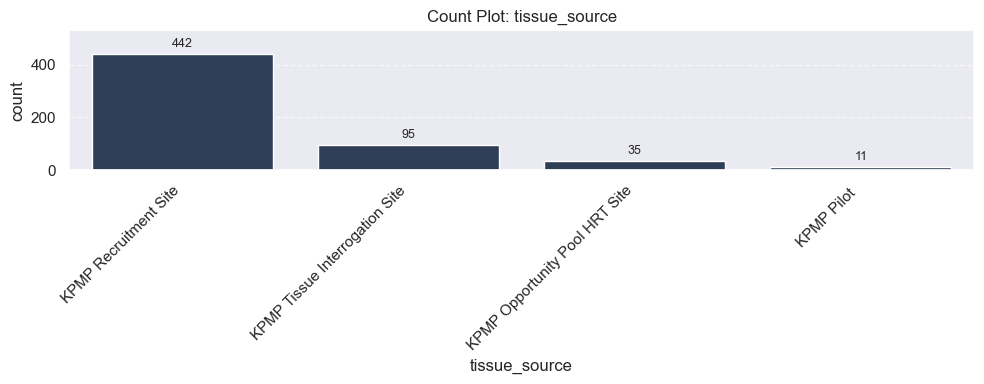

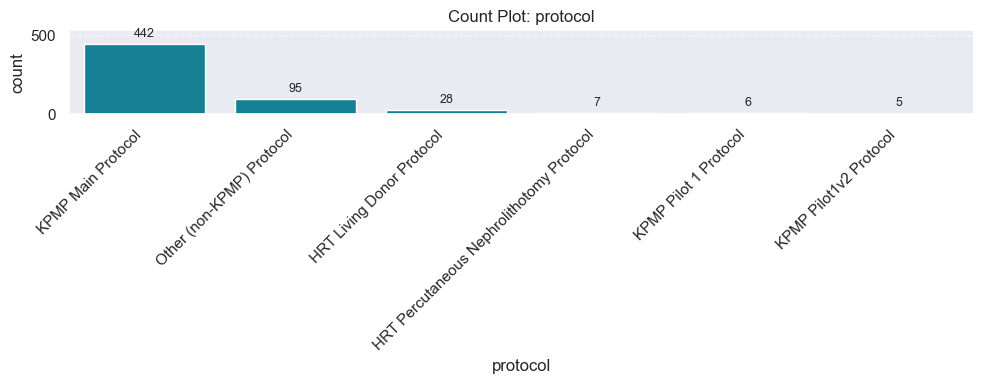

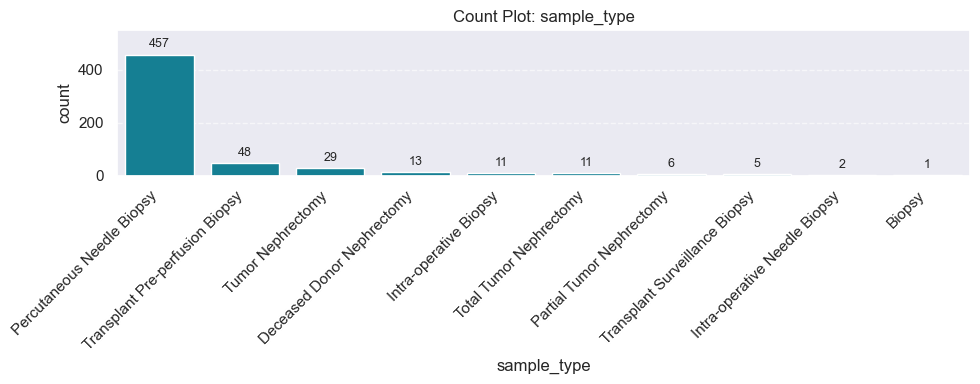

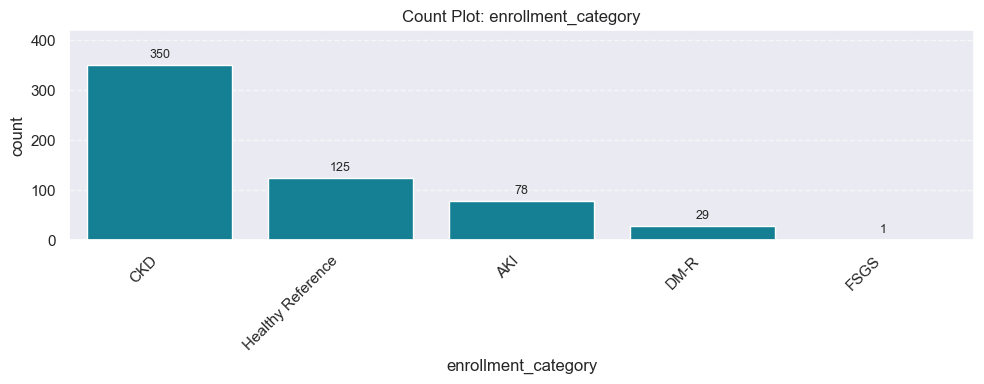

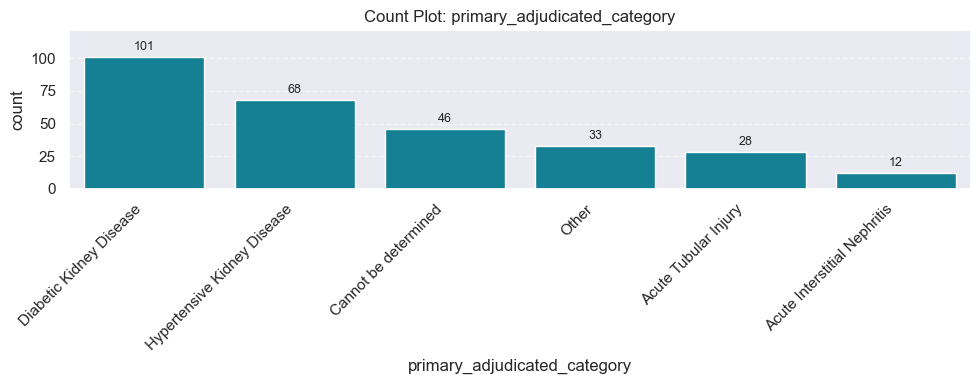

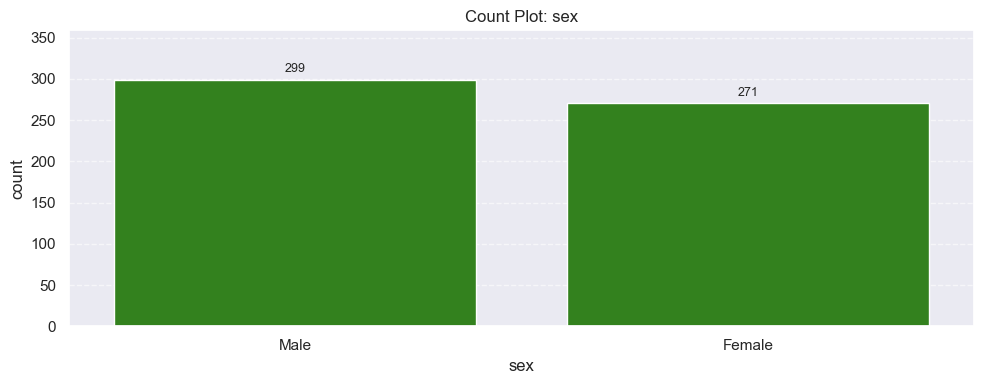

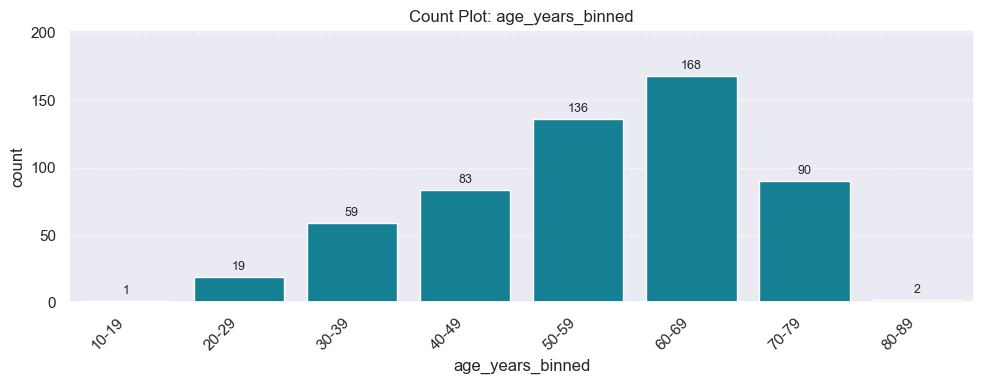

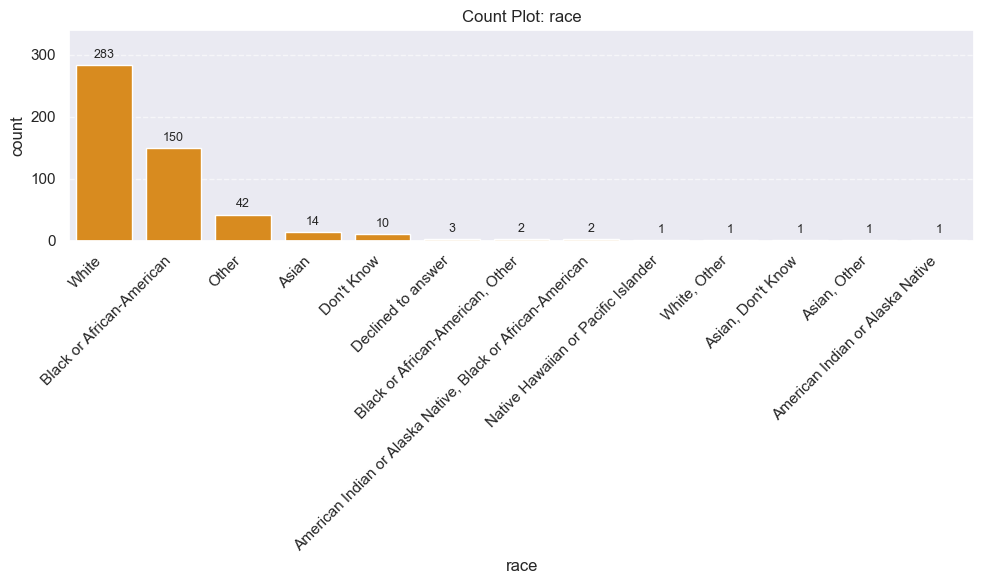

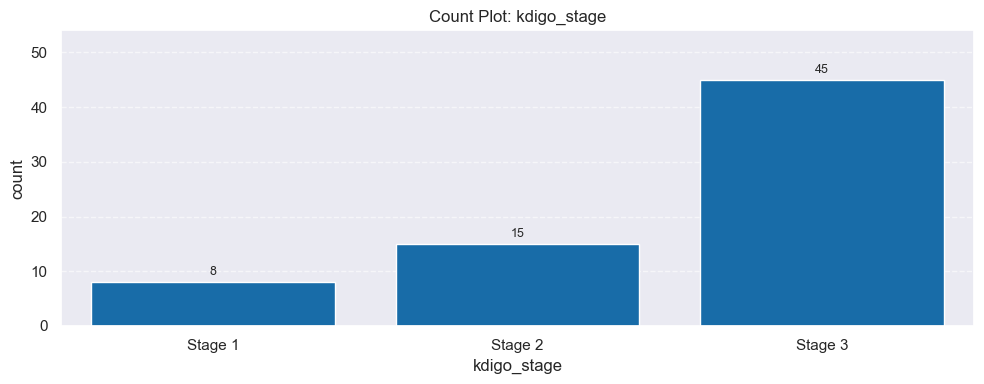

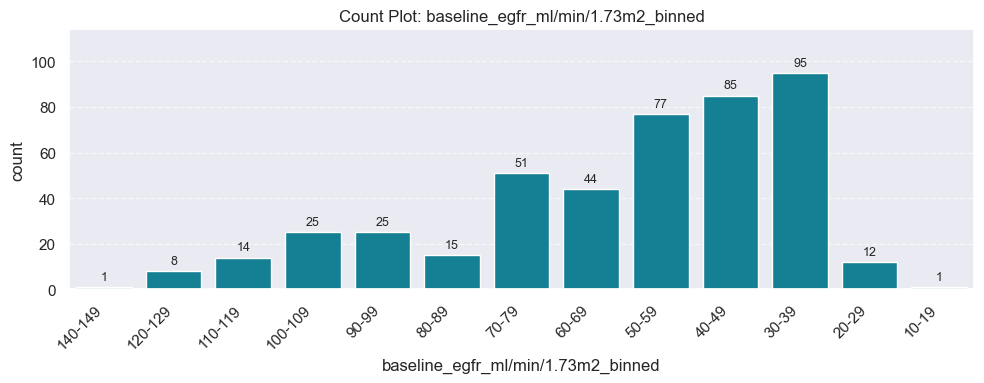

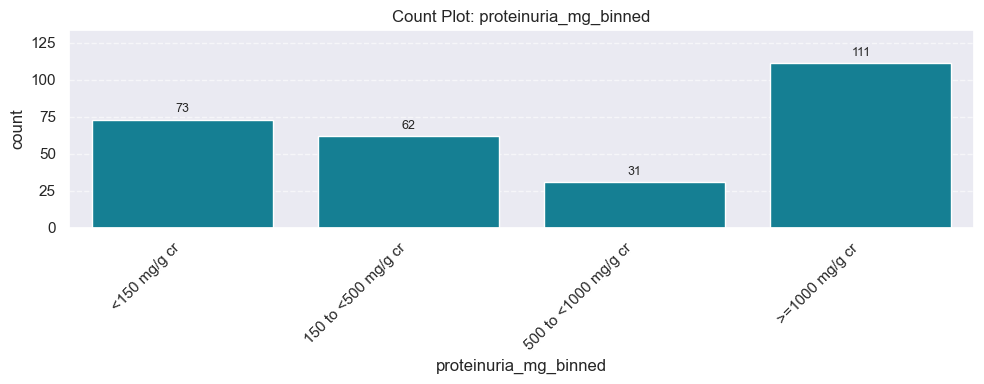

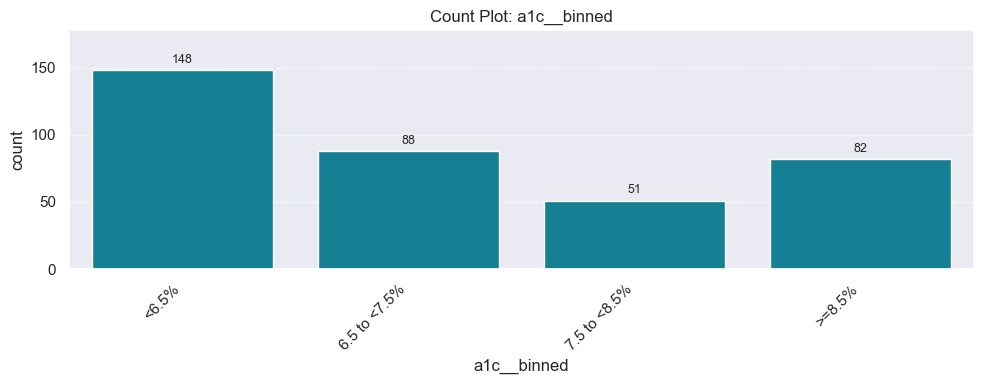

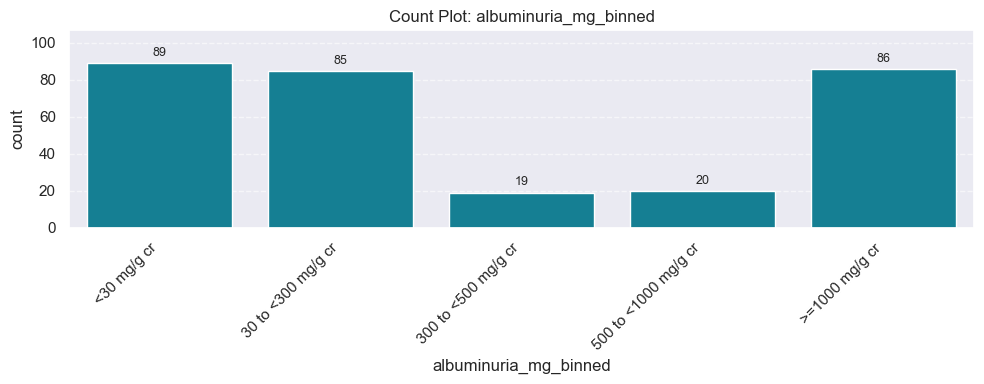

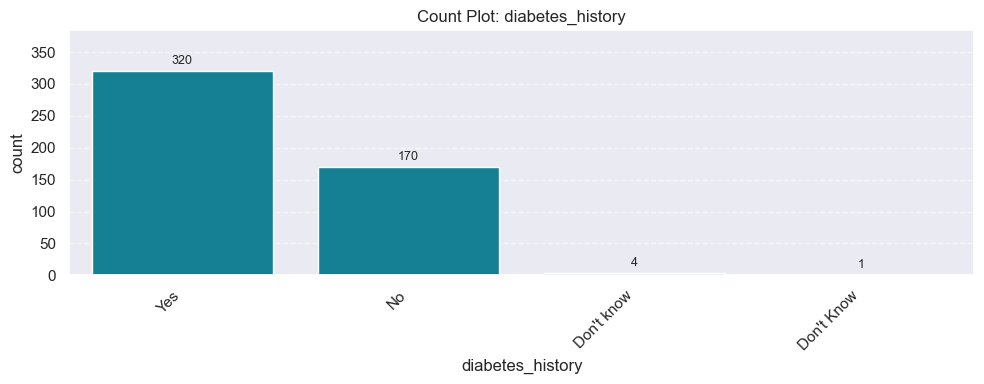

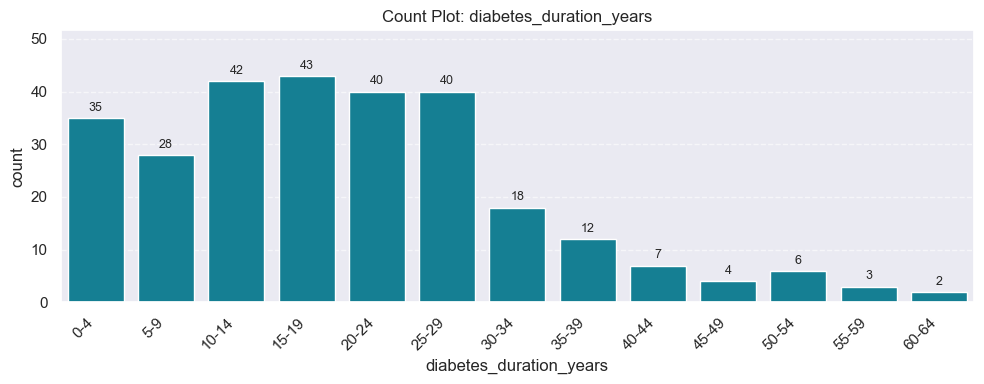

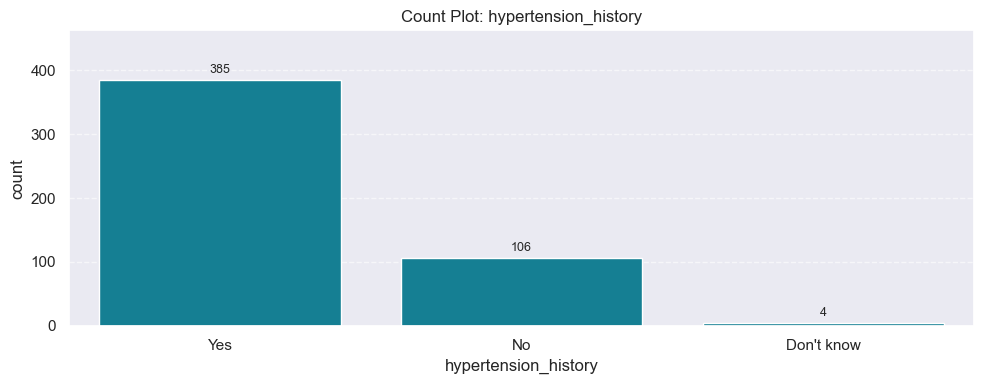

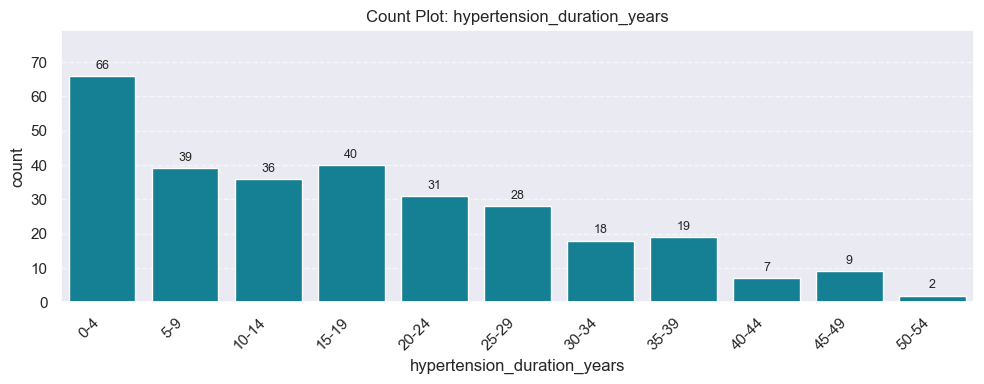

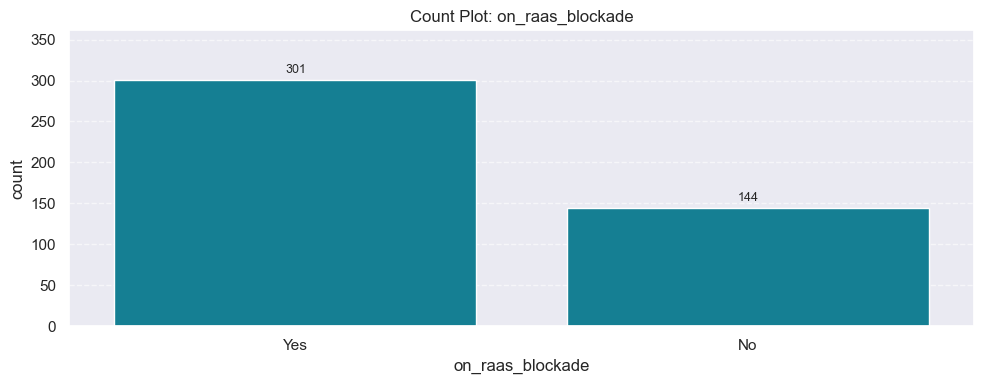

In [16]:
custom_colors = {
    "sex": "#29910D",
    "race": "#F79000",
    "kdigo_stage": "#0070c0",
    "egfr_bins": "#bb0606",
    "tissue_source": "#283C5E"
}

for col in all_cols:
    plot_clinical_column(
        adata, 
        col, 
        color=custom_colors.get(col, "#008ea8")  # use custom or fallback color
    )


In [ ]:
## Single variable category plots

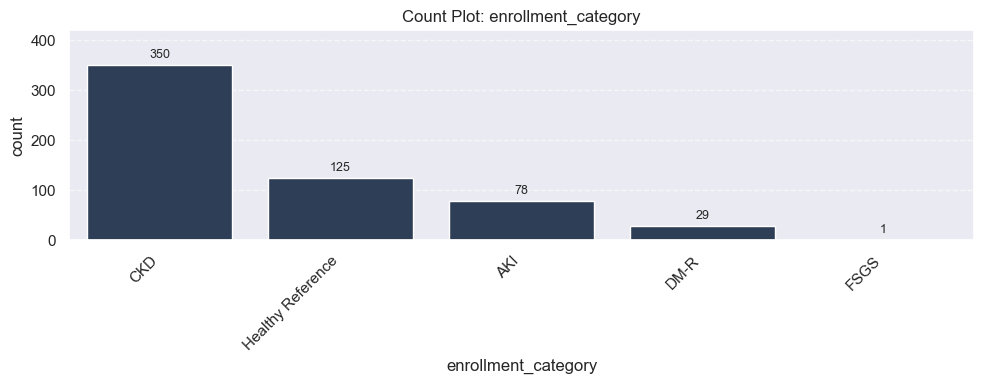

In [17]:
plot_clinical_column(adata, "enrollment_category")

In [ ]:
## Save function added with DPI setting

In [22]:
def plot_clinical_column(adata, column, figsize=(10, 4), save_path=None, dpi=300):
    data = adata.obs[column]

    if column == "race":
        figsize = (10, 6)

    plt.figure(figsize=figsize)

    skip_rotation = {"sex", "kdigo_stage", "hypertension_history", "on_raas_blockade"}
    bin_orders = adata.uns.get("bin_orders", {})
    order = bin_orders.get(column, data.value_counts().index)

    if pd.api.types.is_numeric_dtype(data):
        sns.histplot(data.dropna(), bins=10, kde=False, color="#008ea8")
        plt.title(f"Histogram: {column}")
    else:
        ax = sns.countplot(x=data, order=order, color="#283c5e")
        plt.title(f"Count Plot: {column}")

        if column not in skip_rotation:
            plt.xticks(rotation=45, ha="right")

        max_height = 0
        for container in ax.containers:
            heights = [bar.get_height() for bar in container]
            max_height = max(max_height, *heights)
            ax.bar_label(container, label_type='edge', padding=3, fontsize=9)

        padded_top = max_height * 1.2
        ax.set_ylim(top=padded_top)

    plt.tight_layout()
    
    # Save if a path is given - add path and filename, and dpi
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")
    
    plt.show()

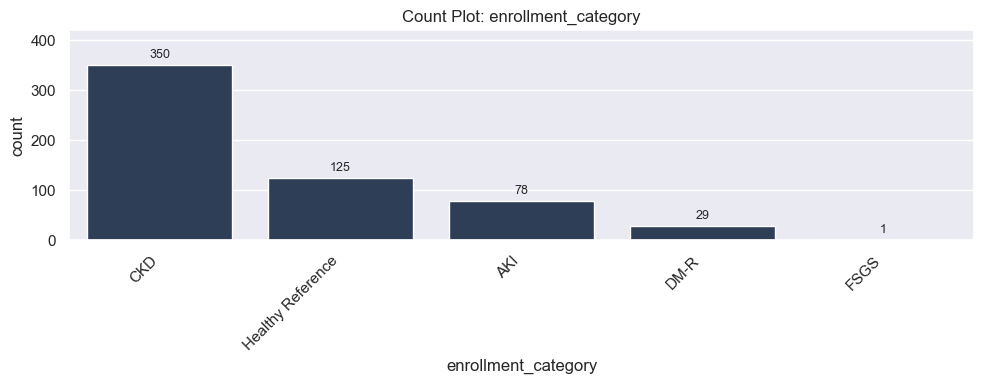

In [23]:
plot_clinical_column(adata, "enrollment_category", save_path="enrollment_category.png", dpi=600)